<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  🏫 FIT@HCMUS, VNU-HCM 🏫
</div>
<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Lab 02 - Data Visualization 
    <div style="text-align: center; background-color: #0A60BD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    Working with Time-series data 
</div>

<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 4 - Data Modelling 📌
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
processed_df = pd.read_csv('../data/Processed.csv')
processed_df

Sum_PASSENGERS  AIRLINE_ID                 CARRIER_NAME ORIGIN  \
0                   130     19385.0  Reeve Aleutian Airways Inc.    ADK   
1                   196     19385.0  Reeve Aleutian Airways Inc.    ADK   
2                   198     19385.0  Reeve Aleutian Airways Inc.    ADK   
3                   155     19385.0  Reeve Aleutian Airways Inc.    ADK   
4                   167     19385.0  Reeve Aleutian Airways Inc.    ADK   
...                 ...         ...                          ...    ...   
6278358               5     22074.0                  Avon Jet AG    MFE   
6278359               2     22074.0                  Avon Jet AG    PBI   
6278360               6     22074.0                  Avon Jet AG    TEB   
6278361               3     22074.0                  Avon Jet AG    TEB   
6278362               2     22074.0                  Avon Jet AG    TEB   

                       ORIGIN_CITY_NAME ORIGIN_STATE_NM ORIGIN_COUNTRY_NAME  \
0                       Adak Island, AK          Alaska       United States   
1                       Adak Island, AK          Alaska       United States   
2                       Adak Island, AK          Alaska       United States   
3                       Adak Island, AK          Alaska       United States   
4                       Adak Island, AK          Alaska       United States   
...                                 ...             ...                 ...   
6278358    Mission/McAllen/Edinburg, TX           Texas       United States   
6278359  West Palm Beach/Palm Beach, FL         Florida       United States   
6278360                   Teterboro, NJ      New Jersey       United States   
6278361                   Teterboro, NJ      New Jersey       United States   
6278362                   Teterboro, NJ      New Jersey       United States   

        DEST               DEST_CITY_NAME DEST_STATE_NM DEST_COUNTRY_NAME  \
0        ANC                Anchorage, AK        Alaska     United States   
1        ANC                Anchorage, AK        Alaska     United States   
2        ANC                Anchorage, AK        Alaska     United States   
3        ANC                Anchorage, AK        Alaska     United States   
4        ANC                Anchorage, AK        Alaska     United States   
...      ...                          ...           ...               ...   
6278358  VCE                Venice, Italy       Unknown             Italy   
6278359  FAB  Farnborough, United Kingdom       Unknown    United Kingdom   
6278360  ATH               Athens, Greece       Unknown            Greece   
6278361  FRA           Frankfurt, Germany       Unknown           Germany   
6278362  KEF  Keflavik/Reykjavik, Iceland       Unknown           Iceland   

         YEAR  MONTH  
0        2000      1  
1        2000      2  
2        2000      3  
3        2000      4  
4        2000      5  
...       ...    ...  
6278358  2020      3  
6278359  2020      3  
6278360  2020      7  
6278361  2020     10  
6278362  2020      6  

[6278363 rows x 13 columns]

## Phân tích tổng quát về dữ liệu số lượng hành khách theo thời gian

In [3]:
df = processed_df[['Sum_PASSENGERS', 'YEAR', 'MONTH']]
df = df.groupby(['YEAR', 'MONTH'])['Sum_PASSENGERS'].sum().reset_index()
df['Date'] = df.apply(lambda row: f"{row['MONTH']}-{row['YEAR']}", axis=1)
df.set_index(['Date'], inplace=True)
df

YEAR  MONTH  Sum_PASSENGERS
Date                                
1-2000   2000      1        51746681
2-2000   2000      2        53586897
3-2000   2000      3        64945087
4-2000   2000      4        61985071
5-2000   2000      5        64346421
...       ...    ...             ...
6-2020   2020      6        17040790
7-2020   2020      7        24827610
8-2020   2020      8        26295714
9-2020   2020      9        26257897
10-2020  2020     10        31153583

[250 rows x 3 columns]

## Tổng quan dữ liệu

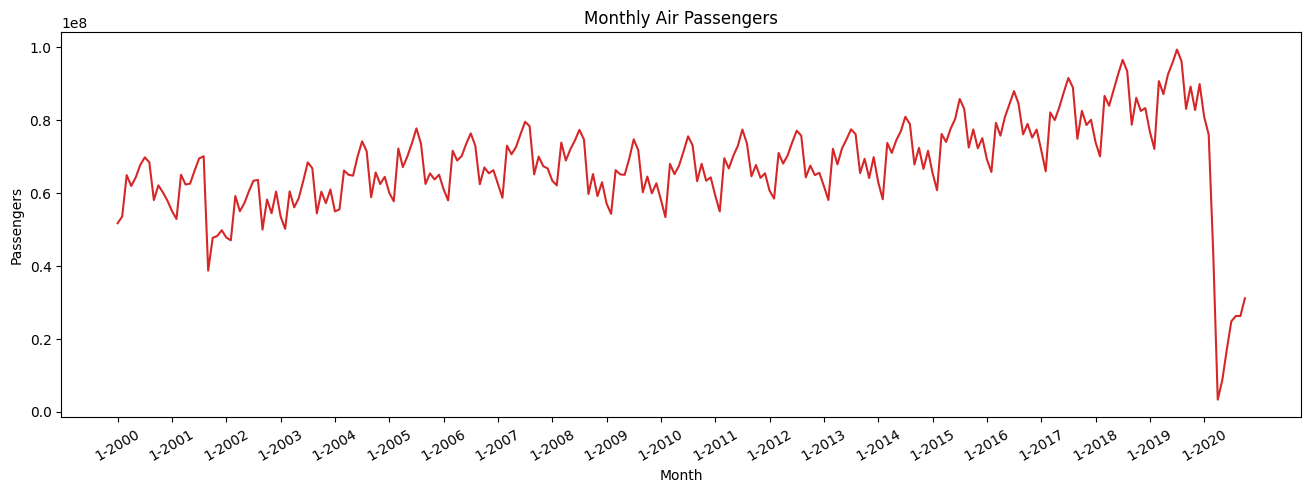

In [4]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df.index, df['Sum_PASSENGERS'], color='tab:red')
plt.gca().set(title='Monthly Air Passengers', xlabel='Month', ylabel='Passengers')
xticks = [i for i, value in enumerate(df.index) if i % 12 == 0]
plt.xticks(xticks, df.index[xticks], rotation=30)
plt.show()

Thấy được dữ liệu thay đổi đột ngột khoảng tháng 2/2020 (tháng thứ 242) vì một vài lí do. Nên ta tạm dùng data từ tháng 1 đến tháng thứ 242 để đảm bảo tính chu kỳ trong việc phân tích và dự đoán.

In [5]:
df = df[:242]

## Phân tách dữ liệu time series thành các yếu tố xu hướng, chu kỳ và dao động ngẫu nhiên

Phân tích bổ sung (additive decomposition) là một phương pháp phân tích chuỗi thời gian để tách các thành phần chính của chuỗi thời gian thành các phần tử cộng lại với nhau. Phương pháp này cho rằng giá trị của chuỗi thời gian là tổng của các thành phần: xu hướng (trend), yếu tố mùa vụ (seasonality), và thành phần dao động ngẫu nhiên (residuals).

Trong phân tích bổ sung, ta giả định rằng giá trị của chuỗi thời gian có thể được biểu diễn bằng công thức: **Y(t) = T(t) + S(t) + R(t)**

Trong đó:

- Y(t) là giá trị của chuỗi thời gian tại thời điểm `t`.
- T(t) là thành phần xu hướng (trend) tại thời điểm `t`, biểu thị xu hướng chung của chuỗi thời gian.
- S(t) là thành phần yếu tố mùa vụ (seasonality) tại thời điểm `t`, biểu thị sự biến đổi theo chu kỳ trong chuỗi thời gian.
- R(t) là thành phần dao động ngẫu nhiên (residuals) tại thời điểm `t`, biểu thị sự dao động ngẫu nhiên không thể giải thích được bởi xu hướng và yếu tố mùa vụ.

Vì các phương pháp học máy chỉ áp dụng với kiểu dữ liệu datetime nhưng dữ liệu của chúng ta không có thông tin về ngày nên sẽ đặt mặc định là 1

In [6]:
df.index = pd.to_datetime(df.index, format='%m-%Y')
df

YEAR  MONTH  Sum_PASSENGERS
Date                                   
2000-01-01  2000      1        51746681
2000-02-01  2000      2        53586897
2000-03-01  2000      3        64945087
2000-04-01  2000      4        61985071
2000-05-01  2000      5        64346421
...          ...    ...             ...
2019-10-01  2019     10        89246813
2019-11-01  2019     11        82823145
2019-12-01  2019     12        89976874
2020-01-01  2020      1        80964134
2020-02-01  2020      2        76071817

[242 rows x 3 columns]

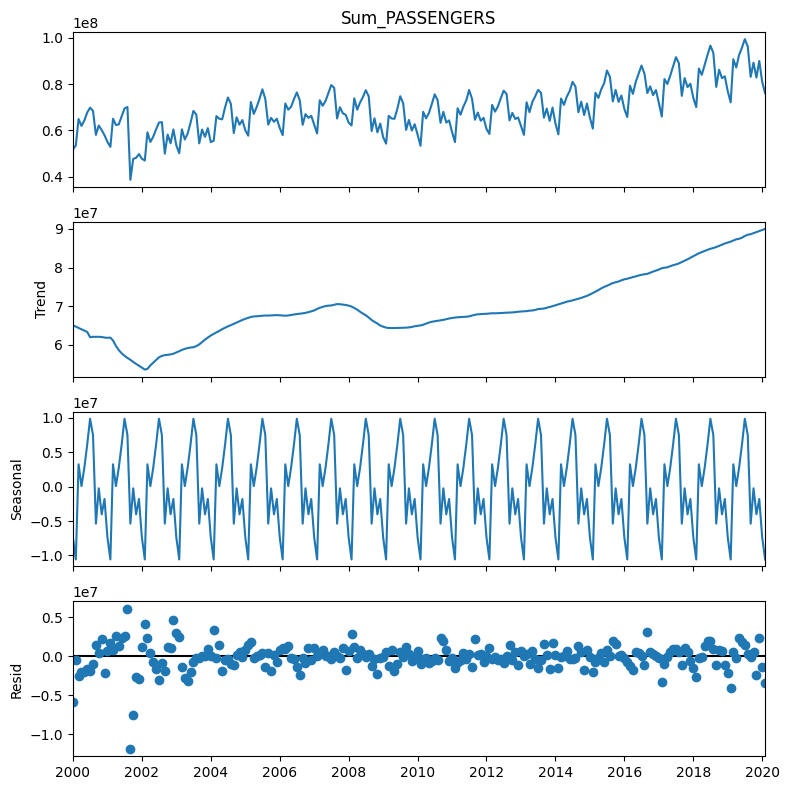

In [7]:
result_add = seasonal_decompose(df['Sum_PASSENGERS'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (8,8)})
result_add.plot()
plt.show()

## Quan sát

- Dựa vào biểu đồ Trend, dữ liệu có dao dộng với xu hướng chính là tăng lên theo thời gian.
- Dựa vào biểu đồ Seasonal, dữ liệu có chu kỳ theo từng năm. 

## Phân tích 1 chu kì (1 năm)

Ta sẽ xem xét số lượng hành khách trong năm 2010 làm đại diện vì các năm khác đều tương tự.

### 1. Mục đích

- Phân tích và đánh giá sự thay đổi số lượng hành khách trong 1 năm diễn ra như thế nào.
- Đưa ra cái nhìn tổng quan về hoạt động di chuyển hàng không của người dân xuyên suốt 1 năm.

### 2. Phân tích

In [8]:
passengers_2010 = df[df['YEAR'] == 2010]
passengers_2010

YEAR  MONTH  Sum_PASSENGERS
Date                                   
2010-01-01  2010      1        58221756
2010-02-01  2010      2        53422555
2010-03-01  2010      3        68065719
2010-04-01  2010      4        65229536
2010-05-01  2010      5        67543699
2010-06-01  2010      6        71457434
2010-07-01  2010      7        75612702
2010-08-01  2010      8        73129863
2010-09-01  2010      9        63297061
2010-10-01  2010     10        68064795
2010-11-01  2010     11        63421471
2010-12-01  2010     12        64348632

### 3. Trực quan hóa

Sử dụng biểu đồ đường để thể hiện được sự thay đổi số lượng hành khách qua từng tháng.

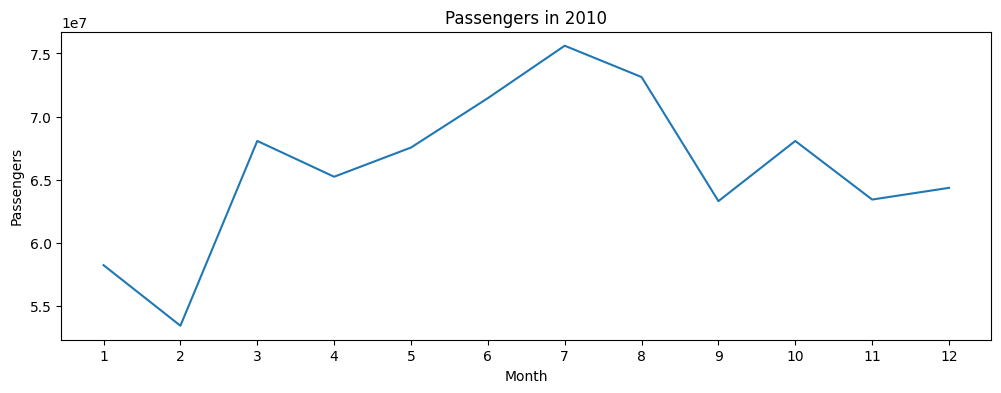

In [9]:
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(passengers_2010['MONTH'], passengers_2010['Sum_PASSENGERS'])
plt.xlabel('Month')
plt.xticks(passengers_2010['MONTH'])
plt.ylabel('Passengers')
plt.title('Passengers in 2010')
plt.show()

### 4. Quan sát

Dựa vào biểu đồ, ta có thể thấy:

- Xu hướng chung của biểu đồ:
    - Số lượng hành khách giảm từ tháng 1 đến thấp nhất vào tháng 2
    - Sau đó tăng mạnh vào tháng 3, tiếp tục và cao nhất vào tháng 7
    - Giảm mạnh từ đến tháng 9 sau đó tăng trở lại và ổn định từ tháng 11 đến tháng 12
- Tháng 7 là tháng có số lượng hành khách cao nhất, lí do và vì đây là khoảng thời gian mùa hè và các kỳ nghỉ của người dân Mỹ nên nhu cầu đi lại hay du lịch tăng cao.
- Tháng 2 có số lượng hành khách thấp nhất vì đây là tháng mùa đông, thời tiết xấu và ít kỳ nghỉ nên hoạt động di chuyển của người dân hạn chế.
- Số lượng hành khách tăng lên trong mùa hè và giảm vào mùa thu. Cụ thể là tăng nhẹ vào tháng 10, có thể liên quan đến các kỳ nghỉ lớn ở Mỹ như Halloween và lễ Tạ Ơn vào tháng 11.

# Phần ML: Dự đoán số hành khách của các tháng dựa vào các tháng trước đó

## Sử dụng thuật toán SARIMA để dự đoán

In [10]:
train = df['Sum_PASSENGERS'][:201]
test = df['Sum_PASSENGERS'][201:]

Các tham số p, d, q, P, D, Q, s của mô hình Sarima đã được tinh chỉnh và thử nghiệm nhiều lần để chọn ra bộ tham số hiệu quả nhất đới với dữ liệu.

In [11]:
# Xây dựng mô hình
model = SARIMAX(train, order=(3, 1, 2), seasonal_order=(3, 2, 2, 12))
fitted = model.fit()

# Dự đoán
fc = fitted.forecast(41, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)

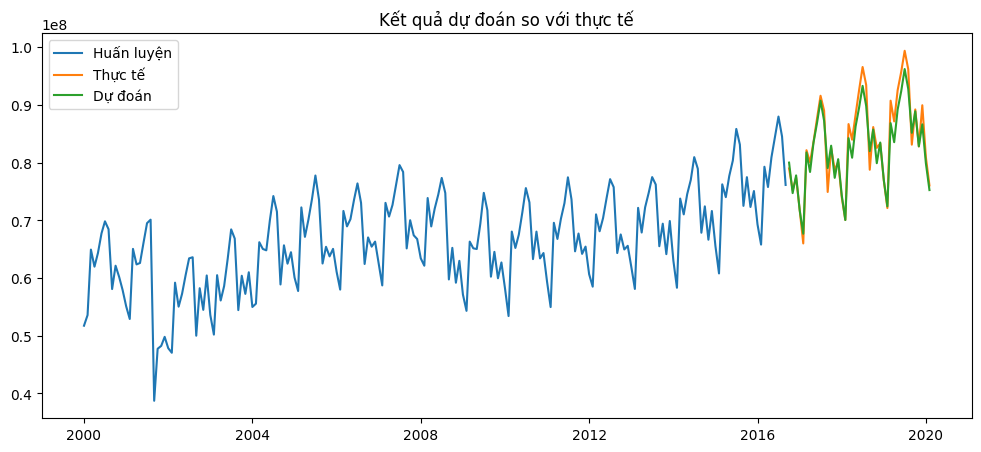

In [12]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Huấn luyện')
plt.plot(test, label='Thực tế')
plt.plot(fc_series, label='Dự đoán')
plt.title('Kết quả dự đoán so với thực tế')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [13]:
# Phần trăm sai lệch
mae = mean_absolute_error(test.values, fc_series.values)
percentage_error = (mae / np.mean(test.values)) * 100
print(f"Phần trăm sai lệch: {round(percentage_error, 4)}%")

Phần trăm sai lệch: 1.998%


Sai lệch giá trị dự đoán so với giá trị thực chỉ khoảng 2%